# ViT assignment

colab의 경우, 런타임 유형을 GPU로 바꿔주세요.

In [3]:
%env DEVICE=mps
%env CUDA_VISIBLE_DEVICES=
%env TF_METAL_ENABLE=1

env: DEVICE=mps
env: CUDA_VISIBLE_DEVICES=
env: TF_METAL_ENABLE=1


# 0. Setting

In [4]:
# Install required library
!pip install einops

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from einops import repeat
from einops.layers.torch import Rearrange
from torch import Tensor
import math
import time

# 1. Project input to patches

In [6]:
class PatchProjection(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        # 이미지를 패치로 나눈 후 총 패치 개수 계산
        # 224x224 이미지를 16x16 패치로 나누면 (224/16) * (224/16) = 14 * 14 = 196개 패치
        self.num_patches = (img_size // patch_size) ** 2

        self.projection = nn.Sequential(
            # TODO: 패치 임베딩을 위한 핵심 레이어 (Conv2d)와 차원 재배치(Rearrange)를 완성하세요            
            # Conv2d를 사용해 각 패치를 임베딩 벡터로 변환
            # kernel_size=patch_size: 패치 크기만큼의 컨볼루션 커널 사용
            # stride=patch_size: 패치가 겹치지 않도록 스트라이드를 패치 크기와 동일하게 설정
            # 입력: (batch, in_channels, height, width) -> 출력: (batch, emb_size, h_patches, w_patches)
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            
            # Rearrange를 사용해 차원 재배치
            # (batch, emb_size, h_patches, w_patches) -> (batch, h_patches*w_patches, emb_size)
            # 'b e h w -> b (h w) e': 패치들을 시퀀스 형태로 평탄화
            Rearrange('b e h w -> b (h w) e')
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        # TODO: 입력 이미지를 patch embedding으로 변환하는 부분 완성
        # 입력 이미지를 projection을 통해 패치 임베딩으로 변환
        # self.projection을 활용해 patch embedding을 수행
        # 입력: (batch, channels, height, width) 
        # 출력: (batch, num_patches, emb_size)
        return self.projection(x)


# Test
if __name__ == "__main__":
    x = torch.randn(8, 3, 224, 224)
    patch_proj = PatchProjection()
    out = patch_proj(x)
    print(f'Input shape: {x.shape}')
    print(f'Patch embeddings shape: {out.shape}')
    print(f'Number of patches: {patch_proj.num_patches}')

Input shape: torch.Size([8, 3, 224, 224])
Patch embeddings shape: torch.Size([8, 196, 768])
Number of patches: 196


# 2. Patches embedding

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2  # 이미지 크기와 패치 크기에 따른 총 패치 수 계산
        
        # Patch projection
        self.projection = nn.Sequential(
            # TODO: 패치 임베딩을 위한 핵심 레이어 (Conv2d)와 차원 재배치(Rearrange)를 완성하세요
            # Conv2d를 사용해 각 패치를 임베딩 벡터로 변환
            # kernel_size=patch_size: 패치 크기만큼의 컨볼루션 커널 사용
            # stride=patch_size: 패치가 겹치지 않도록 스트라이드를 패치 크기와 동일하게 설정
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            # Rearrange를 사용해 차원 재배치
            # (batch, emb_size, h_patches, w_patches) -> (batch, h_patches*w_patches, emb_size)
            Rearrange('b e h w -> b (h w) e')
        )

        # CLS token and positional encoding
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn(self.num_patches + 1, emb_size))

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.positions, std=0.02)

    def forward(self, x: Tensor) -> Tensor:
        B = x.shape[0]

        # Project to patches
        # TODO: self.projection을 활용해 patch embedding을 수행하세요.
        # self.projection을 활용해 patch embedding을 수행
        # 입력: (batch, channels, height, width) -> 출력: (batch, num_patches, emb_size)
        x = self.projection(x)

        # Add CLS token
        # TODO: batch 크기에 맞게 cls_token을 확장하고 입력에 연결하세요.

        # batch 크기에 맞게 cls_token을 확장하고 입력에 연결
        # cls_token을 batch 크기만큼 반복: (1, 1, emb_size) -> (batch, 1, emb_size)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=B)
        # 패치 임베딩 앞에 CLS 토큰 추가: (batch, num_patches+1, emb_size)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional encoding
        # TODO: positional encoding을 더하세요.
        # positional encoding을 더해줌 (브로드캐스팅을 통해 batch 차원에 자동으로 적용)
        # positions shape: (num_patches+1, emb_size)
        # x shape: (batch, num_patches+1, emb_size)
        x = x + self.positions

        return x

# Test
if __name__ == "__main__":
    x = torch.randn(8, 3, 224, 224)
    patch_emb = PatchEmbedding()
    out = patch_emb(x)
    print(f'Input shape: {x.shape}')
    print(f'Output shape: {out.shape}')
    print(f'Expected: (8, 197, 768)') # 196 patches + 1 CLS token

Input shape: torch.Size([8, 3, 224, 224])
Output shape: torch.Size([8, 197, 768])
Expected: (8, 197, 768)


# 3. Multi Head Attention (MHA)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.scale = self.head_dim ** -0.5

        assert emb_size % num_heads == 0

        # Q, K, V projections
        # TODO: Q, K, V를 한 번에 만드는 선형레이어와
        #       출력 투영 선형레이어를 선언하세요.
        #       bias는 qkv에선 False로, proj에선 True(기본)로 둡니다.
        self.qkv = nn.Linear(emb_size, emb_size * 3, bias=False)  # Q, K, V를 한번에 생성
        self.proj = nn.Linear(emb_size, emb_size)  # 출력 투영 레이어
        self.dropout = nn.Dropout(dropout)  # Dropout 레이어

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.constant_(self.proj.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        B, N, C = x.shape

        # Generate Q, K, V
        # TODO: qkv 선형레이어로 Q,K,V 생성 후 (B, N, 3, num_heads, head_dim)으로 reshape 하고,
        #       (3, B, num_heads, N, head_dim)으로 permute하여 q,k,v로 분리하세요.
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention computation
        # TODO: scaled dot-product attention 계산 후 softmax, dropout 적용
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Scaled dot-product
        attn = attn.softmax(dim=-1)  # Softmax로 attention weights 계산
        attn = self.dropout(attn)  # Dropout 적용

        # Apply attention to values
        # TODO: attention 결과에 v를 곱하고,
        #       (B, N, C) 형태로 reshape 후 proj와 dropout 적용
        x = attn @ v  # attention weights와 values 곱셈
        x = x.transpose(1, 2).reshape(B, N, C)  # (B, num_heads, N, head_dim) -> (B, N, C)
        x = self.proj(x)  # 출력 projection
        x = self.dropout(x)  # Dropout 적용

        return x


# Test
if __name__ == "__main__":
    x = torch.randn(8, 197, 768)  # (batch, patches+cls, emb_size)
    mha = MultiHeadAttention()
    out = mha(x)
    print(f'Input shape: {x.shape}')
    print(f'Output shape: {out.shape}')
    print(f'Parameters: {sum(p.numel() for p in mha.parameters()):,}')

Input shape: torch.Size([8, 197, 768])
Output shape: torch.Size([8, 197, 768])
Parameters: 2,360,064


# 4. Transformer Encoder Block

In [9]:
class MLP(nn.Module):
    def __init__(self, emb_size=768, mlp_ratio=4, dropout=0.1):
        super().__init__()
        hidden_size = int(emb_size * mlp_ratio)

        self.net = nn.Sequential(
            # TODO: nn.Sequential을 활용해
            #       emb_size -> hidden_size -> emb_size 순서의 MLP를 만드세요.
            #       중간에 GELU와 Dropout 포함
            nn.Linear(emb_size, hidden_size),  # 첫 번째 선형 레이어: emb_size -> hidden_size
            nn.GELU(),  # GELU 활성화 함수
            nn.Dropout(dropout),  # Dropout
            nn.Linear(hidden_size, emb_size),  # 두 번째 선형 레이어: hidden_size -> emb_size
            nn.Dropout(dropout)  # 최종 Dropout
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        self.scale = self.head_dim ** -0.5

        # TODO: qkv, proj linear 레이어 선언 및 dropout 선언
        # qkv는 bias=False, proj는 기본
        self.qkv = nn.Linear(emb_size, emb_size * 3, bias=False)  # Q, K, V를 한번에 생성
        self.proj = nn.Linear(emb_size, emb_size)  # 출력 투영 레이어
        self.dropout = nn.Dropout(dropout)  # Dropout 레이어

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.constant_(self.proj.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        B, N, C = x.shape

        # TODO: qkv 생성, reshape, permute 후 q,k,v 분리
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # TODO: scaled dot-product attention 계산, softmax, dropout 적용
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Scaled dot-product
        attn = attn.softmax(dim=-1)  # Softmax로 attention weights 계산
        attn = self.dropout(attn)  # Dropout 적용

        # TODO: attention 결과와 v 곱하고, 다시 proj와 dropout 적용
        x = attn @ v  # attention weights와 values 곱셈
        x = x.transpose(1, 2).reshape(B, N, C)  # (B, num_heads, N, head_dim) -> (B, N, C)
        x = self.proj(x)  # 출력 projection
        x = self.dropout(x)  # Dropout 적용

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # TODO: LayerNorm 2개, MultiHeadAttention, MLP 선언
        self.norm1 = nn.LayerNorm(emb_size)  # 첫 번째 LayerNorm (attention 전)
        self.norm2 = nn.LayerNorm(emb_size)  # 두 번째 LayerNorm (MLP 전)
        self.attention = MultiHeadAttention(emb_size, num_heads, dropout)  # Multi-Head Attention
        self.mlp = MLP(emb_size, mlp_ratio, dropout)  # MLP

    def forward(self, x: Tensor) -> Tensor:
        # Pre-norm + residual connection for attention
        x = x + self.attention(self.norm1(x))

        # Pre-norm + residual connection for MLP
        x = x + self.mlp(self.norm2(x))

        return x


# Test
if __name__ == "__main__":
    x = torch.randn(8, 197, 768)
    block = TransformerEncoderBlock()
    out = block(x)
    print(f'Input shape: {x.shape}')
    print(f'Output shape: {out.shape}')
    print(f'Parameters: {sum(p.numel() for p in block.parameters()):,}')

Input shape: torch.Size([8, 197, 768])
Output shape: torch.Size([8, 197, 768])
Parameters: 7,085,568


# 5. Complete ViT

In [10]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=1000,
        emb_size=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        dropout=0.1,
        drop_path=0.0
    ):
        super().__init__()

        # Patch embedding (from Stage 2)
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)

        # Transformer encoder blocks (from Stage 4)
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(emb_size, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        nn.init.constant_(self.head.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        # TODO: patch embedding 적용
        # 입력 이미지를 패치 임베딩으로 변환 (CLS 토큰과 positional encoding 포함)
        x = self.patch_embed(x)

        # TODO: Transformer encoder blocks 순차 적용
        # 모든 Transformer 블록을 순차적으로 통과
        for block in self.blocks:
            x = block(x)

        # Classification head (use CLS token)
        x = self.norm(x)
        cls_token = x[:, 0]  # Extract CLS token
        x = self.head(cls_token)

        return x


# Test
if __name__ == "__main__":
    # ViT-Base configuration
    model = VisionTransformer(
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=1000,
        emb_size=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        dropout=0.1
    )

    x = torch.randn(2, 3, 224, 224)
    out = model(x)

    print(f'Input shape: {x.shape}')
    print(f'Output shape: {out.shape}')
    print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')

    # Different ViT configurations
    print('\n=== ViT Configurations ===')
    configs = {
        'ViT-Tiny': {'emb_size': 192, 'depth': 12, 'num_heads': 3},
        'ViT-Small': {'emb_size': 384, 'depth': 12, 'num_heads': 6},
        'ViT-Base': {'emb_size': 768, 'depth': 12, 'num_heads': 12},
        'ViT-Large': {'emb_size': 1024, 'depth': 24, 'num_heads': 16},
    }

    for name, config in configs.items():
        model = VisionTransformer(**config, num_classes=1000)
        params = sum(p.numel() for p in model.parameters())
        print(f'{name}: {params:,} parameters')

Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 1000])
Total parameters: 86,540,008

=== ViT Configurations ===
ViT-Tiny: 5,710,504 parameters
ViT-Small: 22,036,840 parameters
ViT-Base: 86,540,008 parameters
ViT-Large: 304,252,904 parameters


# 6. ViT for CIFAR-10

위의 코드를 완성했다면, 아래 코드를 실행하여 전체 모델을 테스트할 수 있습니다.

In [12]:
class ViTCIFAR10(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        emb_size=256,
        depth=6,
        num_heads=8,
        mlp_ratio=4,
        dropout=0.1
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(emb_size, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        if hasattr(self.patch_embed, 'cls_token'):
            nn.init.trunc_normal_(self.patch_embed.cls_token, std=0.02)
        if hasattr(self.patch_embed, 'positions'):
            nn.init.trunc_normal_(self.patch_embed.positions, std=0.02)

    def forward(self, x: Tensor) -> Tensor:
        x = self.patch_embed(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        cls_token = x[:, 0]
        x = self.head(cls_token)

        return x


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}: Loss {loss.item():.4f}, Acc {100.*correct/total:.2f}%')

    return running_loss / len(dataloader), 100. * correct / total


def test(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(dataloader)
    accuracy = 100. * correct / total

    return test_loss, accuracy


def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

    model = ViTCIFAR10(
        img_size=32,
        patch_size=4,
        num_classes=10,
        emb_size=256,
        depth=6,
        num_heads=4,
        dropout=0.1
    ).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=5e-4,
        weight_decay=0.03,
        betas=(0.9, 0.999)
    )

    num_epochs = 30
    warmup_epochs = 1
    total_steps = len(train_loader) * num_epochs
    warmup_steps = len(train_loader) * warmup_epochs
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_acc = 0
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        for _ in range(len(train_loader)):
            scheduler.step()

        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'LR: {current_lr:.6f}, Epoch time: {epoch_time:.2f}s')

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'vit_cifar10_best.pth')

        if test_acc > 90.0:
            print(f"Reached target accuracy!")
            break

    print(f'\nBest Test Accuracy: {best_acc:.2f}%')


if __name__ == "__main__":
    model = ViTCIFAR10(emb_size=256, depth=6, num_heads=4)
    x = torch.randn(4, 3, 32, 32)
    out = model(x)

    print(f'Input shape: {x.shape}')
    print(f'Output shape: {out.shape}')
    print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

    main()

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 10])
Parameters: 4,766,474

Epoch 1/30
Batch 0: Loss 2.3315, Acc 9.38%
Batch 100: Loss 2.3220, Acc 12.58%
Train Loss: 2.3273, Train Acc: 12.39%
Test Loss: 2.3256, Test Acc: 12.30%
LR: 0.000500, Epoch time: 294.64s

Epoch 2/30
Batch 0: Loss 2.3422, Acc 12.89%
Batch 100: Loss 1.8474, Acc 27.15%
Train Loss: 1.9391, Train Acc: 31.13%
Test Loss: 1.8123, Test Acc: 37.74%
LR: 0.000499, Epoch time: 292.70s

Epoch 3/30
Batch 0: Loss 1.8759, Acc 34.38%
Batch 100: Loss 1.7513, Acc 40.46%
Train Loss: 1.7424, Train Acc: 41.71%
Test Loss: 1.6540, Test Acc: 46.37%
LR: 0.000494, Epoch time: 291.53s

Epoch 4/30
Batch 0: Loss 1.6579, Acc 43.36%
Batch 100: Loss 1.7286, Acc 45.18%
Train Loss: 1.6384, Train Acc: 46.98%
Test Loss: 1.5830, Test Acc: 49.87%
LR: 0.000487, Epoch time: 300.59s

Epoch 5/30
Batch 0: Loss 1.5691, Acc 50.78%
Batch 100: Loss 1.5304, Acc 49.75%
Train Loss: 1.5700, Train Acc: 50.24%
Test Loss: 1.5550, Test Acc: 51.54%

ViT는 일반적으로 대규모 데이터셋에서 사전 학습된(pretrained) 모델을 활용하는 경우가 많기 때문에, 하이퍼파라미터를 조정하거나 학습 epoch을 늘리면 성능이 개선될 수는 있지만, 소규모 데이터셋에서 처음부터 학습한 ViT의 성능이 낮은 것은 구조적 한계에 가깝습니다.

# 7. Viz

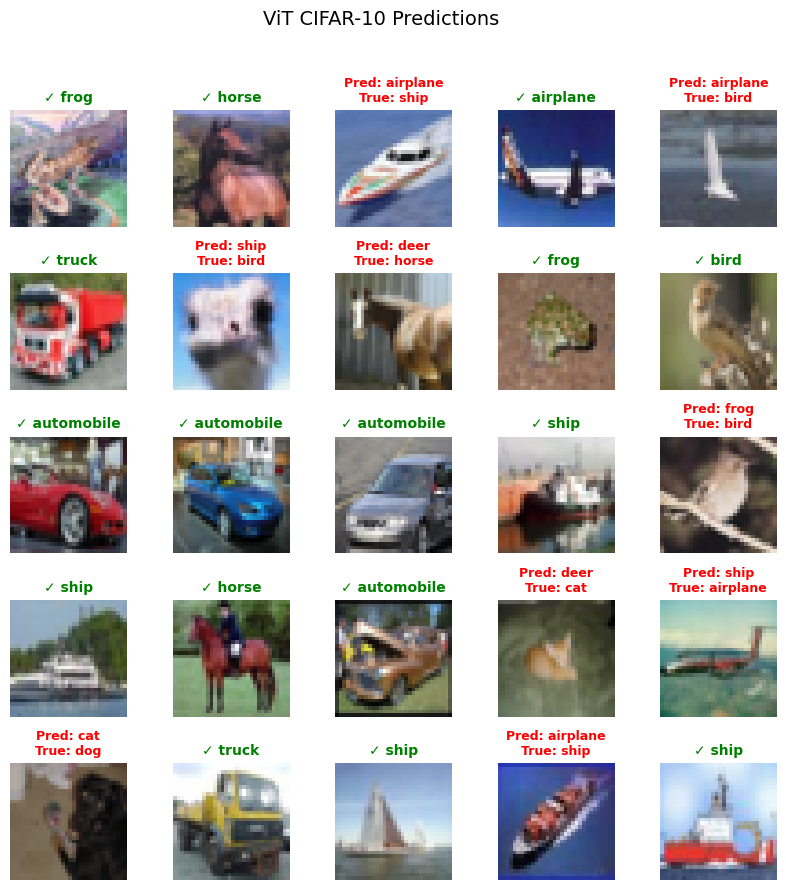


배치 정확도: 64.00% (16/25 맞음)

예측 결과 상세:
   1. ✓ 정답: frog      
   2. ✓ 정답: horse     
   3. ✗ 예측: airplane   (정답: ship      )
   4. ✓ 정답: airplane  
   5. ✗ 예측: airplane   (정답: bird      )
   6. ✓ 정답: truck     
   7. ✗ 예측: ship       (정답: bird      )
   8. ✗ 예측: deer       (정답: horse     )
   9. ✓ 정답: frog      
  10. ✓ 정답: bird      


In [16]:
# 저장된 모델 로드 및 예측 시각화
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model_path='vit_cifar10_best.pth'):
    """저장된 모델로 예측 결과 시각화"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # CIFAR-10 클래스 이름
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 모델 로드
    model = ViTCIFAR10(
        img_size=32,
        patch_size=4,
        num_classes=10,
        emb_size=256,
        depth=6,
        num_heads=4,
        dropout=0.0  # 평가 시에는 dropout 사용 안함
    ).to(device)
    
    # 저장된 가중치 로드
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 테스트 데이터 로드
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=25, shuffle=True)
    
    # 첫 번째 배치 가져오기
    images, labels = next(iter(test_loader))
    images = images.to(device)
    
    # 예측
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # 시각화 - 5x5 그리드로 변경하고 크기 조정
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    
    # 역정규화를 위한 값
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    for idx in range(25):
        ax = axes[idx // 5, idx % 5]
        
        # 이미지 역정규화
        img = images[idx].cpu().numpy()
        img = img.transpose(1, 2, 0)
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # 이미지 표시 - 원본 크기 유지하되 보간법 없이
        ax.imshow(img, interpolation='nearest', aspect='equal')
        ax.axis('off')
        
        # 예측 결과 표시
        pred_class = classes[predicted[idx]]
        true_class = classes[labels[idx]]
        
        # 맞춘 경우와 틀린 경우 구분
        if predicted[idx] == labels[idx]:
            ax.set_title(f'✓ {pred_class}', color='green', fontsize=10, fontweight='bold')
        else:
            ax.set_title(f'Pred: {pred_class}\nTrue: {true_class}', 
                        color='red', fontsize=9, fontweight='bold', linespacing=1.2)
        
        # 테두리 추가
        for spine in ax.spines.values():
            spine.set_edgecolor('lightgray')
            spine.set_linewidth(1)
    
    plt.suptitle('ViT CIFAR-10 Predictions', fontsize=14, y=0.98)
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.savefig('vit_predictions.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 정확도 계산
    correct = (predicted.cpu() == labels).sum().item()
    accuracy = correct / len(labels) * 100
    print(f'\n배치 정확도: {accuracy:.2f}% ({correct}/25 맞음)')
    
    # 클래스별 예측 결과 분석
    print(f'\n예측 결과 상세:')
    for i in range(min(10, len(labels))):  # 처음 10개만 표시
        pred = classes[predicted[i]]
        true = classes[labels[i]]
        if predicted[i] == labels[i]:
            print(f'  {i+1:2d}. ✓ 정답: {true:10s}')
        else:
            print(f'  {i+1:2d}. ✗ 예측: {pred:10s} (정답: {true:10s})')

# 예측 시각화 실행
if __name__ == "__main__":
    visualize_predictions()